<a href="https://colab.research.google.com/github/BeardMaster/flatland/blob/main/Flatland.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro



I t

# Package load



In [29]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import YouTubeVideo
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import math
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import ZeroPadding2D

import cv2
import random


# Data load

In [311]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/flatland_train.npz')

X = data['X']
y = data['y']



0.0


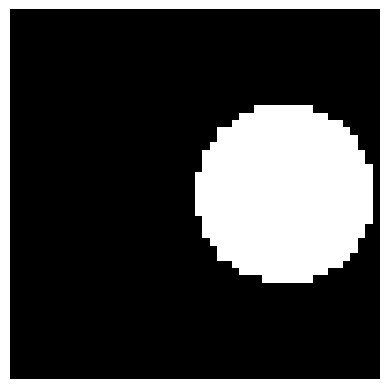

In [302]:
i=5029
plot(X[i])
print(y[i])

Turns out that some labels were  wrong. These are the ones I picked out after training the model well enough and looking at its errors

In [312]:
indices_to_remove=[19, 529, 563, 597, 619, 1403, 1442, 1598, 1748, 1854, 2148, 2226, 2345, 2721, 2748, 3029, 3062, 3357, 3431, 3441, 3798, 3988, 4037, 4068
 , 4168, 4243, 4402, 4452, 4645, 4659, 4804, 4907, 5083, 5130, 5333, 6131, 6155, 6162, 6317, 6517, 6670, 6942, 7093, 7220, 7490, 7575, 7601, 7655,
 7806, 7983, 8068, 8613, 9495, 9664, 9704, 9718, 597, 1238, 1403, 1442, 2105, 2345, 2676, 2978, 3431, 3798, 3988, 4063, 4115, 4243, 4484, 4659, 5056,
                   5083, 5130, 5571, 5909, 6222, 6670, 6679, 6942, 7220, 7806, 7956, 8613, 9566, 9664, 597,
                   1238, 1403, 1442, 2105, 2345, 2676, 2978, 3431, 3798, 3988, 4063, 4115, 4243, 4484, 4659, 5056, 5083, 5130,
                   5571, 5909, 6222, 6670, 6679, 6942, 7220, 7806, 7956, 8613, 9566, 9664, 97, 1238, 1403, 1442, 1474, 2105, 2345, 2676, 2978, 3431, 3798, 3988, 4063, 4115, 4243, 4484, 4659, 5056, 5083, 5130, 5571, 5909, 6222, 6670, 6679, 6942, 7220, 7806, 7956, 8613, 8724, 9566, 9664,
679, 1409, 1467, 2226, 2721, 2752, 2813, 3092, 3249, 3441, 3802, 4037, 4273, 4294, 4488, 5333, 5423, 6006, 6162, 6653, 7557, 7575, 7908, 8585, 8631, 8919,
                   839,473, 505, 756, 1854, 2183, 2225, 2419, 2601, 2748, 2980, 3143, 3894, 3896, 4025, 4094, 4452, 4645, 4759, 4907, 5034, 5375, 5846, 5859, 5996, 6045, 6068, 6559, 6776, 8779, 9089

]

indices_to_remove = np.unique(indices_to_remove)
len(indices_to_remove)
 # Create a mask with True for indices we want to keep
mask = np.ones(len(y), dtype=bool)
mask[indices_to_remove] = False

# Apply the mask
X = X[mask]
y= y[mask]

In [161]:
X.shape
y.shape


(9930,)

In [313]:


y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]


In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


The following step lets increase the  sample size for training of agiven category. The data is generated by rotating/flipping the initial data. This is done only for  training data.

In [273]:
# Specify classes and size of subset
classes_of_interest = [0,4]
n = 200 # Number of samples to add

# Initialize lists for augmented data
augmented_images = []
augmented_labels = []

# Define a small scaling factor
scale_factor = 1  # For example, a 5% increase in size
original_size = 50  # Original image size

for class_label in classes_of_interest:
    class_indices = np.where(y_train == class_label)[0]
    sampled_indices = np.random.choice(class_indices, size=min(n, len(class_indices)), replace=False)

    for idx in sampled_indices:
        image = X_train[idx]

        # Choose a random rotation (90, 180, or 270 degrees)
        rotations = [1, 2, 3]  # Corresponding to 90, 180, 270 degrees
        k = random.choice(rotations)
        rotated_image = np.rot90(image, k)

        # Flip image randomly around horizontal or vertical axis
        flip_horizontal_or_vertical = random.choice([0, 1])
        flipped_image = np.flip(rotated_image, axis=flip_horizontal_or_vertical)

        # Scaling the image by a small constant factor
        scaled_image = cv2.resize(flipped_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

        # Crop the scaled image to maintain the original size
        height, width = scaled_image.shape[:2]
        startx = width//2 - original_size//2
        starty = height//2 - original_size//2
        cropped_image = scaled_image[starty:starty+original_size, startx:startx+original_size]

        # Append to the lists
        augmented_images.append(cropped_image)
        augmented_labels.append(class_label)

# Convert lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate augmented images and labels to the training dataset
X_train_augmented = np.concatenate((X_train, augmented_images), axis=0)
y_train_augmented = np.concatenate((y_train, augmented_labels))

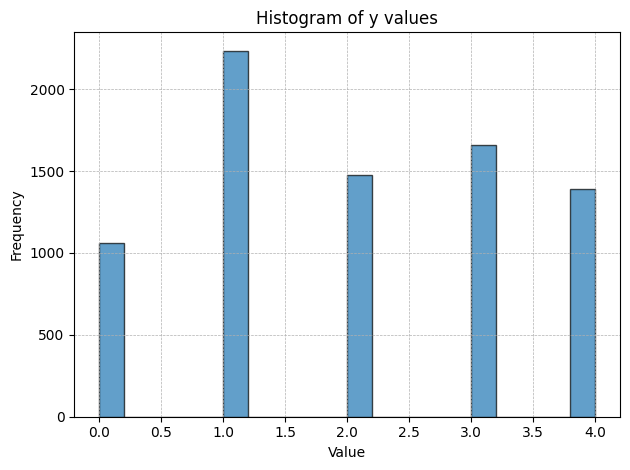

In [61]:
# Create a histogram of y values
plt.hist(y_train, bins='auto', edgecolor='black', alpha=0.7)
plt.title('Histogram of y values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [79]:
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

def apply_filter(X, F):
    x, y = X.shape
    filter_x, filter_y = F.shape
    X_with_filter = np.zeros(shape=(x - filter_x, y - filter_y))

    for i in range(x - filter_x):
        for j in range(y - filter_y):
            X_with_filter[i, j] = (X[i:(i+filter_x), j:(j+filter_y)] * F).sum()

    return X_with_filter

# preproc

Skip this part I ended up not using it

In [ ]:
def pad_n(X, n):
  padded = np.pad(X, [n, n], mode="constant")
  return padded

In [ ]:
def sum_disk(M):
  X = pad_n(M,3)
  x, y = X.shape
  X_disk_counted=np.zeros(shape=M.shape)

  F = np.array([
              [-10, -5, -5, -1, -5, -5, -10],
              [-5, -10, 0, 0, 0, -10, -5],
              [-5, 0, 10, 10, 10, 0, -5],
              [-1, 0, 10, 30, 10, 0, -1],
              [-5, 0, 10, 10, 10, 0, -5],
              [-5, -10, 0, 0, 0, -10, -5],
              [-10, -5, -5, -1, -5, -5, -10]
              ])


  # print(X.shape)
  F_norm=F.sum()
  for i in range(3, x - 4):
        for j in range(3, y - 4):
            X_disk_counted[i-3, j-3] = (X[(i-3):(i+4), (j-3):(j+4)] * F).sum()/F_norm
  return X_disk_counted



In [ ]:
def filter(X, k):
  return (1/k)*np.where(X<k, X, 0)

In [ ]:
def numpy_preprocessing(X):
  # F = np.array([[-1, -1, -1 , -1],
  #             [ -1,  1.5,  1.5, -1],
  #             [ -1,  1.5,  1.5, -1],
  #             [-1, -1, -1, -1]])
  X_proc=np.zeros((X.shape[0], X.shape[1]+12, X.shape[2]+12))
  for i in range(len(X)):
    # T=apply_filter( np.pad(filter(sum_disk(X[i]), 0.01), ([0,4],[0,4]), mode="constant"), F)
    # scale=np.min(T)
    # scaled = (1/scale)*T
    X_proc[i]= pad_n(X[i],6)
  return  X_proc.reshape(X_proc.shape[0], X_proc.shape[1], X_proc.shape[2], 1)
  # return  X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

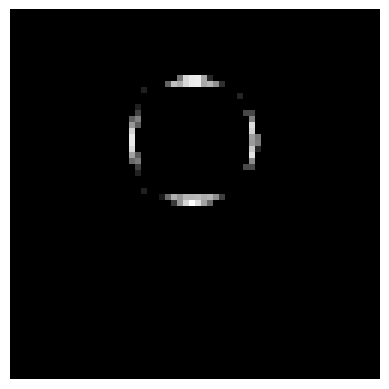

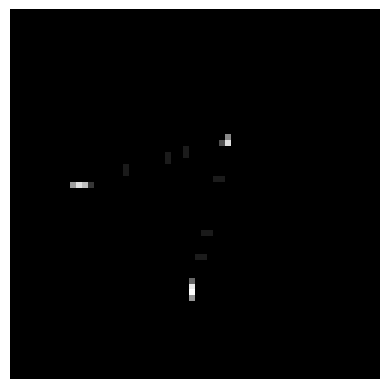

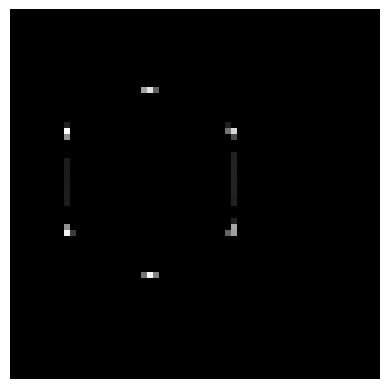

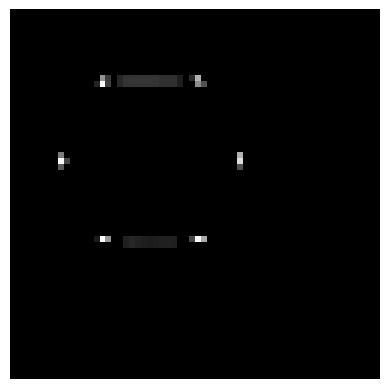

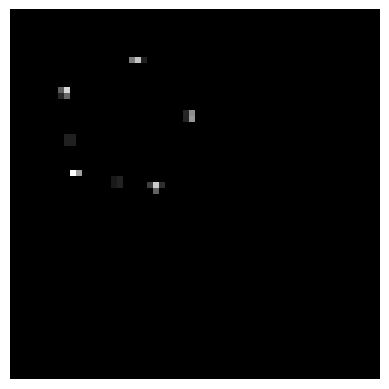

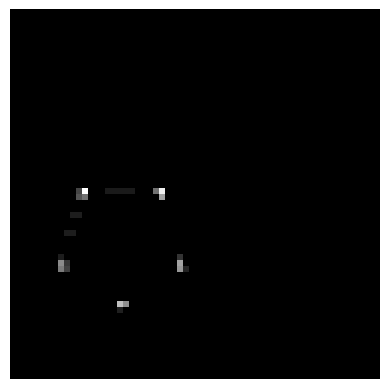

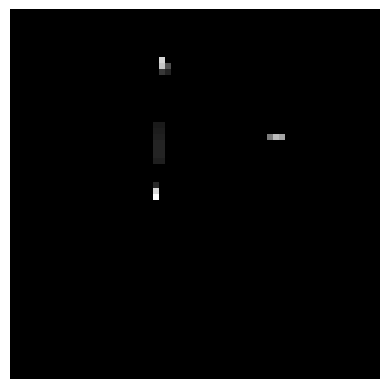

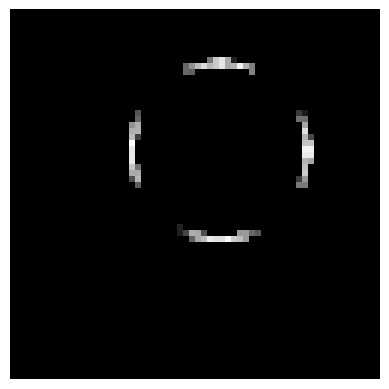

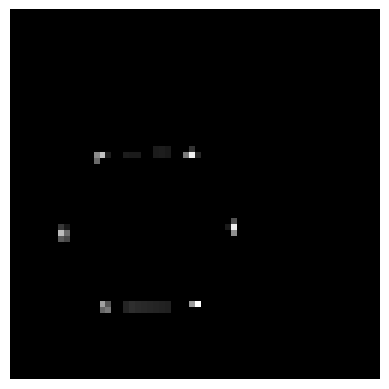

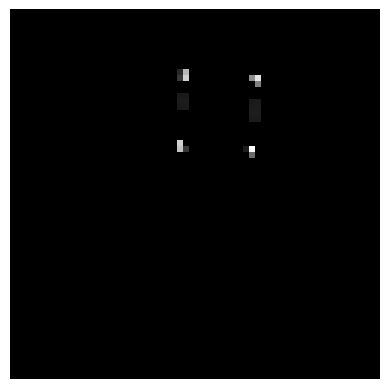

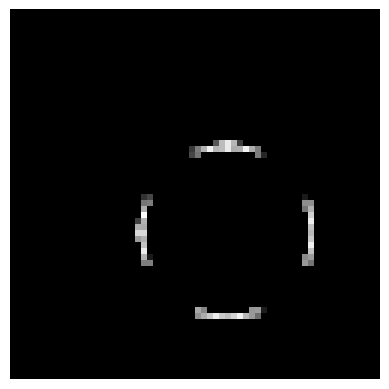

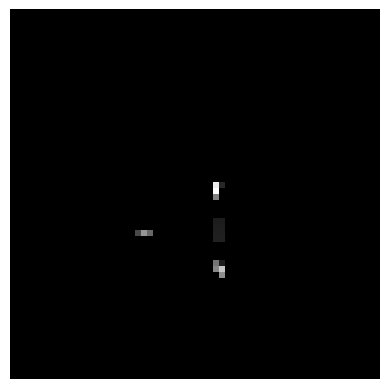

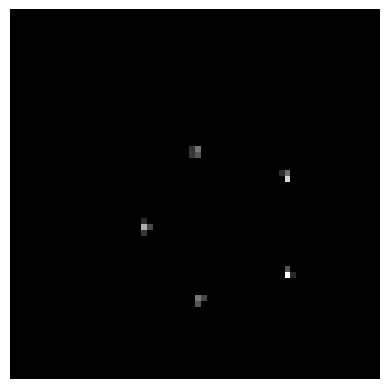

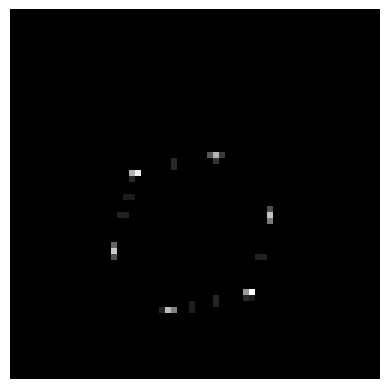

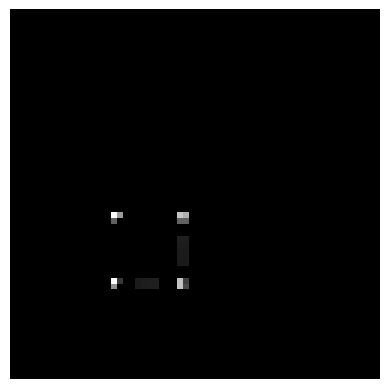

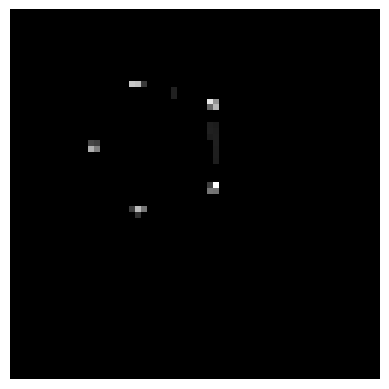

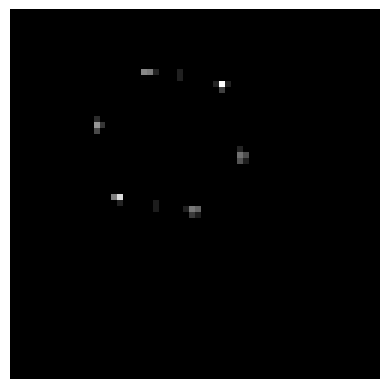

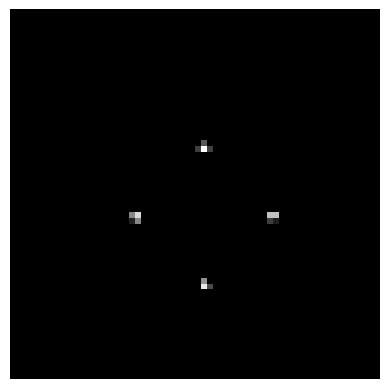

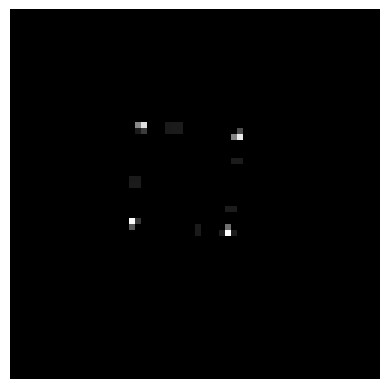

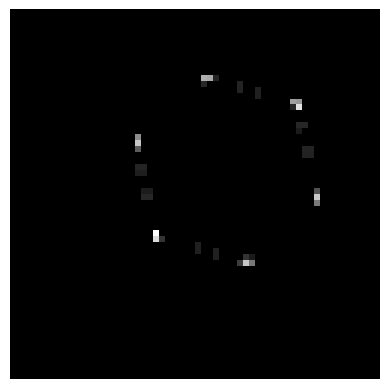

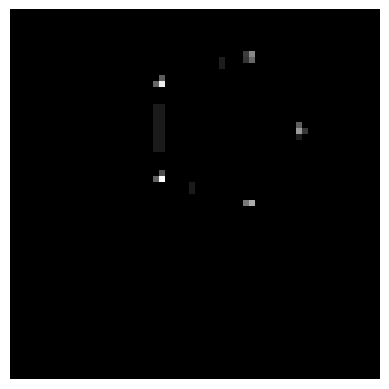

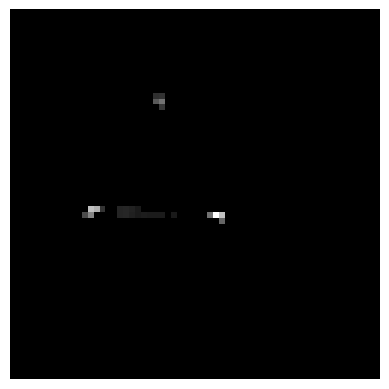

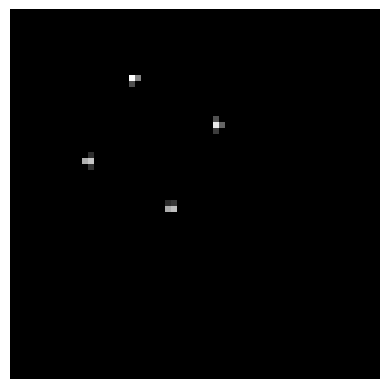

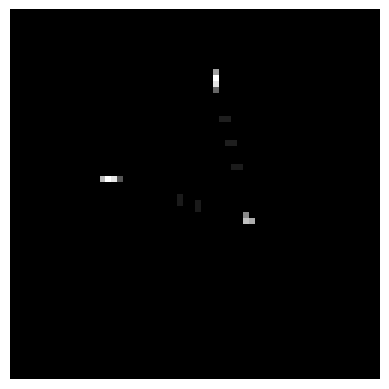

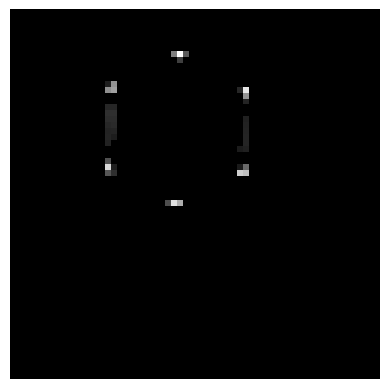

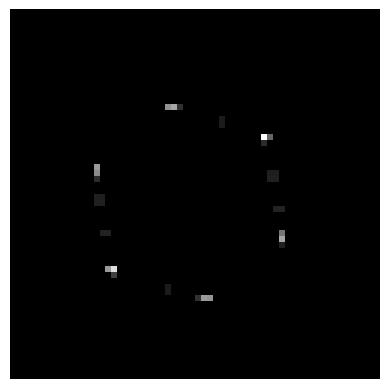

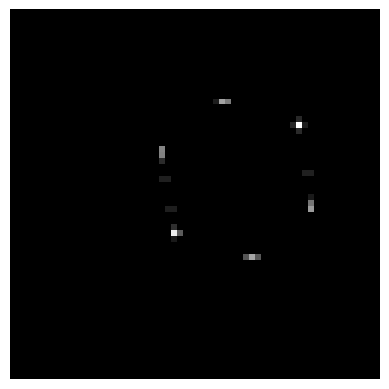

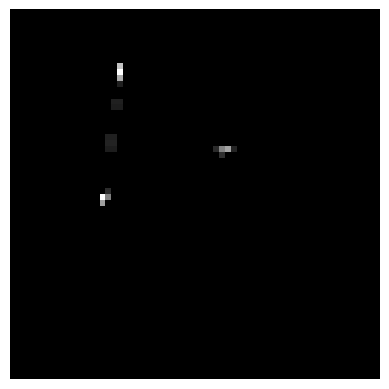

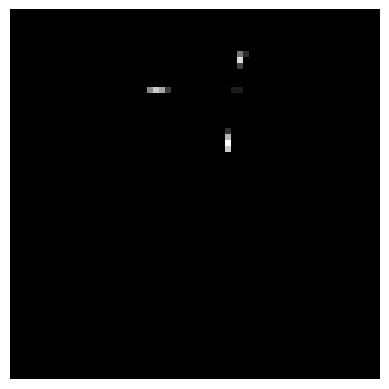

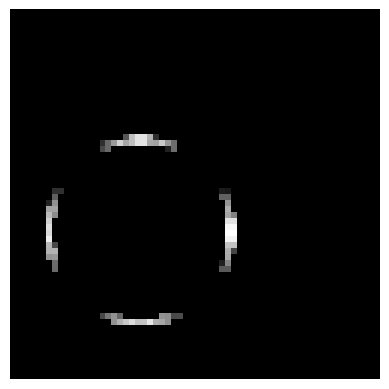

In [ ]:
X_processed = numpy_preprocessing(X_train[0:150])
for i in range(120,150):
  np.max(X_processed[i])
  plot(X_processed[i])
  plt.show()

In [ ]:
def tf_preprocessing_wrapper(input_tensor):
    # Process the input tensor with the numpy_preprocessing function
    processed_tensor = tf.py_function(numpy_preprocessing, [input_tensor], Tout=tf.float32)

    # Explicitly set the shape of the processed_tensor to include the channel dimension
    input_tensor.set_shape([None, 62, 62, 1])  # Assuming each image is 50x50 with 1 channel

    return processed_tensor


# model

In [317]:
model = tf.keras.Sequential([
    # tf.keras.layers.Lambda(tf_preprocessing_wrapper),  # Custom preprocessing
    #ZeroPadding2D(padding=(3, 3), input_shape=(50, 50, 1)),  # padding=(3, 3) adds 3 rows/columns of zeros on each side

    # Convolutional Layer followed by Batch Normalization
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), use_bias=True,  input_shape=(50, 50, 1)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), use_bias=True),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), use_bias=True),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    # Pooling Layer
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    # Flatten the output for the Dense layers
    tf.keras.layers.Flatten(),

    # Dense Layer followed by Batch Normalization
    tf.keras.layers.Dense(128, use_bias=True, kernel_regularizer=l2(0.01)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),

    # Dense Layer followed by Batch Normalization
    tf.keras.layers.Dense(64, use_bias=True, kernel_regularizer=l2(0.01)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),

        # Dense Layer followed by Batch Normalization
    tf.keras.layers.Dense(32, use_bias=True, kernel_regularizer=l2(0.01)),  # Set use_bias=False
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    Dropout(0.2),
    # Output Layer
    tf.keras.layers.Dense(5, activation='softmax') # Adjust according to your task
])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [319]:
# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.0001) # Set your desired learning rate

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [320]:
# 3. Train the Model
num_epochs=40
history= model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_split=0.2)


Epoch 1/40
198/198 [==============================] - 8s 16ms/step - loss: 4.6602 - accuracy: 0.2823 - val_loss: 4.4811 - val_accuracy: 0.1948
Epoch 2/40
198/198 [==============================] - 3s 14ms/step - loss: 4.3201 - accuracy: 0.3491 - val_loss: 4.2440 - val_accuracy: 0.2897
Epoch 3/40
198/198 [==============================] - 3s 14ms/step - loss: 4.1039 - accuracy: 0.4010 - val_loss: 3.9029 - val_accuracy: 0.4681
Epoch 4/40
198/198 [==============================] - 4s 19ms/step - loss: 3.8915 - accuracy: 0.4247 - val_loss: 3.6574 - val_accuracy: 0.5123
Epoch 5/40
198/198 [==============================] - 4s 18ms/step - loss: 3.6888 - accuracy: 0.4632 - val_loss: 3.4240 - val_accuracy: 0.5743
Epoch 6/40
198/198 [==============================] - 3s 14ms/step - loss: 3.4945 - accuracy: 0.4994 - val_loss: 3.2579 - val_accuracy: 0.5971
Epoch 7/40
198/198 [==============================] - 3s 14ms/step - loss: 3.2902 - accuracy: 0.5335 - val_loss: 3.1041 - val_accuracy: 0.6262

In [323]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))
true_classes = y_test

62/62 [==============================] - 0s 7ms/step
Accuracy on test set - 99.29%


In [322]:
pred = model.predict(X).argmax(axis=1)
print('Accuracy entire set - {0:.02%}'.format((pred == y).mean()))
true_classes = y


309/309 [==============================] - 2s 4ms/step
Accuracy entire set - 99.45%


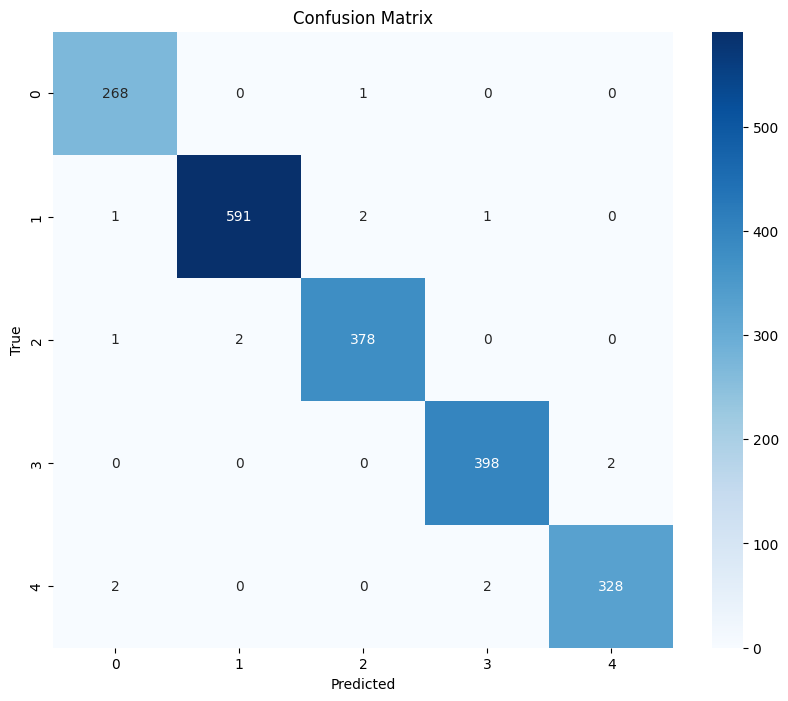

In [324]:
  # Use directly if y_test is already integer labels


# Create the confusion matrix
cm = confusion_matrix(true_classes, pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [176]:
misclassified_indices = np.where(pred != true_classes)[0]
misclassified_indices.shape

(52,)

In [115]:
def bad_shapes(k):
  bad=[]
  for i in misclassified_indices:
    if pred[i] == k:
      bad.append(i)

  print(bad)

In [300]:
bad_shapes(3)

[473, 505, 756, 884, 1854, 2183, 2225, 2419, 2601, 2748, 2980, 3143, 3894, 3896, 4025, 4094, 4452, 4645, 4759, 4907, 5034, 5375, 5846, 5859, 5996, 6045, 6068, 6559, 6776, 7145, 8779, 9089]


In [ ]:
[473, 505, 756,, 1854, 2183, 2225, 2419, 2601, 2748, 2980, 3143, 3894, 3896, 4025, 4094, 4452, 4645, 4759, 4907, 5034, 5375, 5846, 5859, 5996, 6045, 6068, 6559, 6776,  8779, 9089]


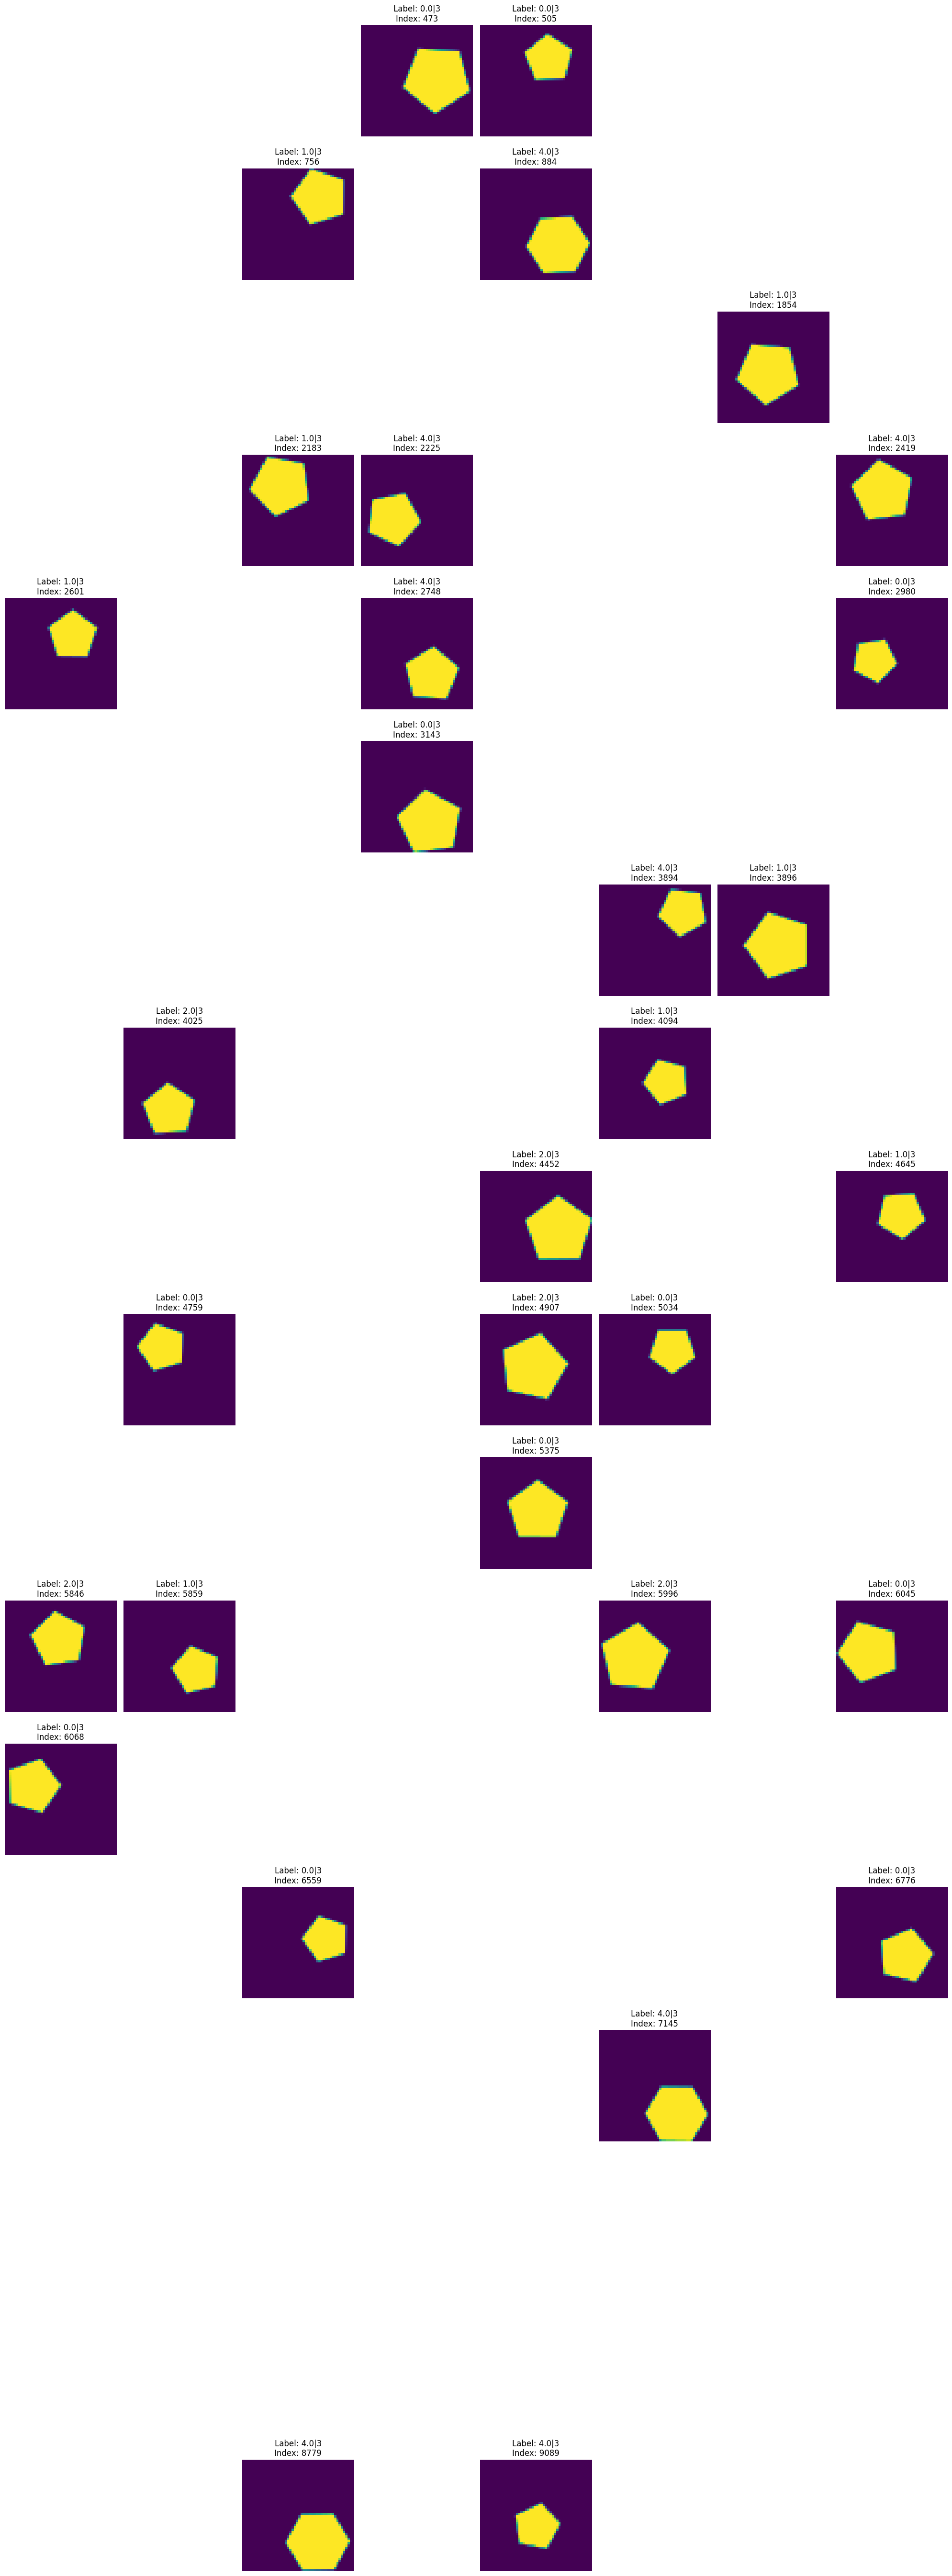

In [299]:
misclassified_indices = np.where(pred != true_classes)[0]
# Define the number of images you want to display
# Set the number of subplots you want
# Number of columns
num_columns = 8

# Calculate the number of rows needed
num_rows = math.ceil(len(misclassified_indices) / num_columns)

# Create a figure with the calculated number of rows and columns
plt.figure(figsize=(20, 3 * num_rows))

# Loop over the elements in misclassified_indices
for idx, i in enumerate(misclassified_indices):
    # Calculate the position of the current subplot
    row = idx // num_columns + 1
    col = idx % num_columns + 1

    # Create a subplot at the calculated position
    if pred[i] == 3:
      plt.subplot(num_rows, num_columns, row * num_columns - num_columns + col)
      plt.imshow(X[i])  # plot the image at index i
      plt.title(f"Label: {y[i]}|{pred[i]}\nIndex: {i}")
      plt.axis('off')  # turn off axis

plt.tight_layout()
plt.show()




In [ ]:
[672, 2782, 3053, 3757, 4216, 4423, 5340, 5912, 7440, 8450, 8493]


In [325]:
# Assuming 'model' is your Keras model
model.save('my_model_19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
